# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [122]:
# Check the present working directory
!pwd

Der Befehl "pwd" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


In [123]:
import requests
import tarfile
import os


def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)



Download completed.
Extracting the file...


C:\Users\MILM004\AppData\Local\Temp\ipykernel_17724\3229291462.py:31: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_to)


Extraction completed.
Downloaded tar.gz file removed.



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [227]:
%pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 4.6 MB/s eta 0:00:33
   ---------------------------------------- 1.6/150.0 MB 4.1 MB/s eta 0:00:37
    --------------------------------------- 2.9/150.0 MB 4.9 MB/s eta 0:00:31
   - -------------------------------------- 4.2/150.0 MB 5.1 MB/s eta 0:00:29
   - -------------------------------------- 5.2/150.0 MB 5.2 MB/s eta 0:00:28
   - -------------------------------------- 6.6/150.0 MB 5.4 MB/s eta 0:00:27
   -- ------------------------------------- 7.6/150.0 MB 5.4 MB/s eta 0:00:27
   -- ------------------------------------- 8.9/150.0 MB 5.4 MB/s eta 0:00:26
   -- ------------------------------------- 10.2/150.0 MB 5.5 MB/s eta 0:00:26
   --- ------------------------------------ 11.3/150.0 MB 5.5 MB/s eta 0:00:26
   --- ------------------------------------ 12.3/150.0 MB 5.4 MB/s eta 0:00:26
   --- ------------------------------------ 13.4/150.0 MB 5.5 MB/s e

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline

# scikit-learn 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import average_precision_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier



## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

**1. Load the datasets**

In [3]:
# Load the first 625000 (aprox. 70% of data) rows from "Udacity_AZDIAS_052018.csv" to avoid memory overload
azdias_sample = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False, nrows=625000)
azdias_sample.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# load the "Udacity_CUSTOMERS_052018.csv" dataset
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
customers.head() 

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**2. We will first start working on the AZDIAS (German General Population), to get a grip of the data:**

In [5]:
azdias_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625000 entries, 0 to 624999
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 1.7+ GB


**2.1. Handle missing values in columns for azdias_sample**

In [6]:
#Let´s now check on missing data:
azdias_sample.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               52180
ALTER_HH                 52180
ALTER_KIND1             568200
                         ...  
WOHNDAUER_2008           52180
WOHNLAGE                 65845
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [7]:
#After checking on the excel "Dias Attributes", we see that the missing data is even bigger that we thought at first. 
#Let´s try to get a full picture of the missing values, by cross-referrencing those: 
DIAS_Attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
DIAS_Attributes.reset_index(drop=True, inplace=True)
del DIAS_Attributes['Unnamed: 0']
DIAS_Attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [8]:
DIAS_Attributes['Attribute'] = DIAS_Attributes['Attribute'].ffill()
DIAS_Attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [9]:
#Based on the excel, let´s identify every value that is actually a NaN value
nan_values = DIAS_Attributes[DIAS_Attributes['Meaning'].str.contains('unknown|no classification possible' , case=False, na=False)]
nan_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [10]:
#Use nan_values as a mapping to replace the values in the azdias_sample dataset to NaN
for attribute in nan_values['Attribute'].dropna().unique():
    if attribute in azdias_sample.columns: 
        # get all the values to replace for each attribute:
        values = nan_values[nan_values['Attribute'] == attribute]['Value']
        
        #flatten, split by coma, strip white spaces and convert to numeric if needed
        replace_vals = pd.Series(','.join(values.dropna().astype(str)).split(',')).str.strip()
        
        #Convert to numeric if the column is numeric:
        if pd.api.types.is_numeric_dtype(azdias_sample[attribute]):
            replace_vals = pd.to_numeric(replace_vals, errors='coerce')
        
        #replace in the azdias_sample
        azdias_sample[attribute] = azdias_sample[attribute].replace(replace_vals.tolist(), np.nan)   

In [11]:
azdias_sample.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [12]:
#Let´s check on the highest percentage of missing data:
nan_percent = azdias_sample.isna().mean().sort_values(ascending=False) * 100
nan_percent.head(20)

ALTER_KIND4                    99.86496
TITEL_KZ                       99.75792
ALTER_KIND3                    99.30128
ALTER_KIND2                    96.69616
ALTER_KIND1                    90.91200
AGER_TYP                       76.98528
EXTSEL992                      73.42272
KK_KUNDENTYP                   65.63376
KBA05_BAUMAX                   53.47632
ALTER_HH                       34.88912
ALTERSKATEGORIE_FEIN           29.60304
D19_LOTTO                      28.92784
D19_SOZIALES                   28.92784
D19_LETZTER_KAUF_BRANCHE       28.92784
D19_VERSAND_ONLINE_QUOTE_12    28.92784
D19_TELKO_ONLINE_QUOTE_12      28.92784
D19_GESAMT_ONLINE_QUOTE_12     28.92784
D19_VERSI_ONLINE_QUOTE_12      28.92784
D19_KONSUMTYP                  28.92784
D19_BANKEN_ONLINE_QUOTE_12     28.92784
dtype: float64

In [13]:
# let´s have a more general approach to the missing data and in the complete dataset:
nan_percent.describe()

count    366.000000
mean      11.411473
std       13.754544
min        0.000000
25%        0.549440
50%       11.949440
75%       13.095360
max       99.864960
dtype: float64

In [14]:
#Based on the statistics on nan_percent, let´s create the necessary bins:
bins = [0, 1, 10, 20, 30, 50, 75, 100]
labels = ['0%', '1-10%', '10-20%', '20-30%', '30-50%', '50-75%', '>75%']

# Transform nan_percent series into these bins
cols_percent_nan = pd.cut(nan_percent, bins=bins, labels=labels, include_lowest=True)

# Count how many columns fall into each category
count_cols = cols_percent_nan.value_counts().sort_index()

print(count_cols)

0%        106
1-10%      15
10-20%    225
20-30%     10
30-50%      1
50-75%      3
>75%        6
Name: count, dtype: int64


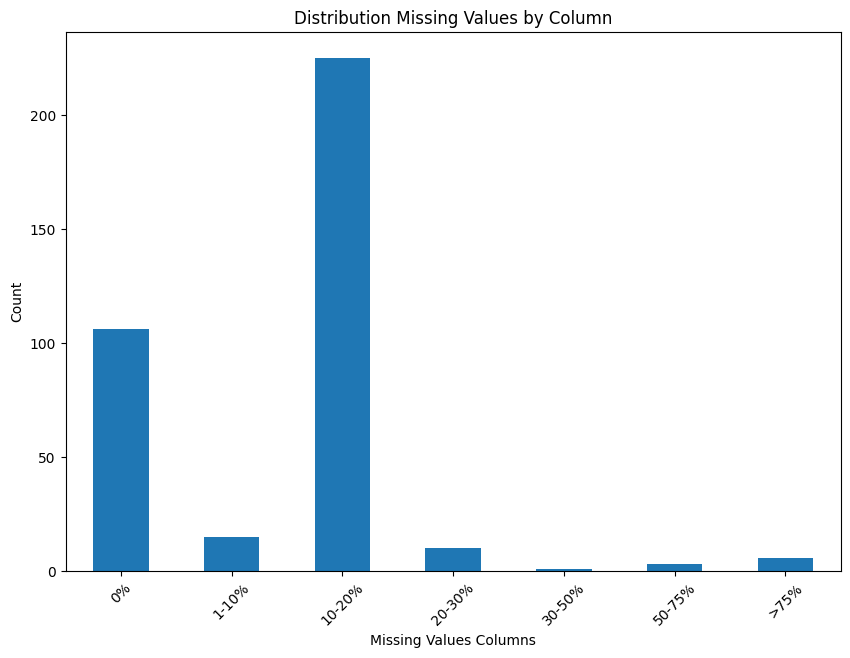

In [15]:
#Now let's visualize the results: 
plt.figure(figsize=(10, 7))
count_cols.plot(kind='bar')
plt.title('Distribution Missing Values by Column')
plt.xlabel('Missing Values Columns')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show();

In [16]:
#Check on the percentage of columns that have more than 20% of missing values 
total_columns = len(nan_percent)
high_missing = nan_percent[nan_percent >= 20]
num_high_missing = high_missing.count()
percent_high_missing = (num_high_missing/ total_columns) * 100
round(percent_high_missing, 2) 

np.float64(5.46)

Based on this information, we can see that: 
- 6 columns have more than 75% missing values 
- 3 columns have between 50% and 75% missing values 
- 1 columsn have 50% missing values
- 10 columns have 20-30% missing values 
- 5.46% of colums have ≥20% missing data


Thanks to the statistics we run on percent_nan, we can also add that: 
- 50% of the columns have around 11,9% missing values 
- 25% of the colums have under 0,5% missing values. 

Therefore, it would make sense to drop columns with ≥20% missing values.
- Imputing them would be unreliable
- Removing them would increase the quality of the data. 


In [17]:
#Drop columns that have ≥20% missing data:
azdias_sample_cleaned = azdias_sample.drop(columns=nan_percent[nan_percent >= 20].index)

In [18]:
#Let´s check if we dropped our columns correctly
nan_percent_cleaned = azdias_sample_cleaned .isna().mean().sort_values(ascending=False) * 100
nan_percent_cleaned.describe()

count    346.000000
mean       8.947127
std        6.256882
min        0.000000
25%        0.137360
50%       11.949440
75%       11.949440
max       17.750400
dtype: float64

**2.2. Handling missing Values azdias_sample_cleaned for rows** 

In [19]:
# Check the rows with nan values and pull the statistics:
nan_rows = azdias_sample_cleaned.isna().sum(axis=1)
missing_rows_percentage = (nan_rows/ azdias_sample_cleaned.shape[1])*100
missing_rows_percentage.describe()

count    625000.000000
mean          8.947127
std          21.344807
min           0.000000
25%           0.000000
50%           0.000000
75%           0.867052
max          71.387283
dtype: float64

We see that 75% of the rows have only 0.8% missing values. This is pretty good.
Now let´s deep-dive into the other 25% of the rows: 

In [20]:
# 75th percentile threshold
q75 = missing_rows_percentage.quantile(0.75)

# Filter for rows above the 75th percentile (i.e., top 25% most missing data)
high_missing_rows = missing_rows_percentage[missing_rows_percentage > q75]
high_missing_rows

0         68.786127
3          1.156069
11        69.075145
12        18.208092
13        19.075145
            ...    
624983    68.786127
624986    69.075145
624990    18.208092
624996    69.075145
624997    68.786127
Length: 141048, dtype: float64

In [21]:
sorted_missing_freqs = high_missing_rows.value_counts().sort_index(ascending=False)
sorted_missing_freqs.head(50)

71.387283        1
70.520231        8
70.231214       24
69.942197        5
69.653179        7
69.364162       19
69.075145    32436
68.786127    19758
65.317919       13
65.028902      310
64.739884      234
64.450867       88
64.161850       71
63.872832     2882
63.583815     7873
63.294798     1985
63.005780      133
62.716763        1
62.427746        1
62.138728        3
61.849711        2
61.560694        4
61.271676        4
60.982659        1
60.693642        1
60.404624        9
59.826590        1
59.537572        4
58.381503        1
58.092486        1
57.803468        6
57.514451        7
57.225434       14
56.936416       31
56.647399       22
56.358382       65
56.069364      237
55.780347       83
55.491329      545
55.202312       87
54.913295      149
54.624277     1562
54.335260       80
54.046243      224
53.757225     1087
53.468208       12
53.179191       29
52.890173       17
52.601156      149
52.312139      218
Name: count, dtype: int64

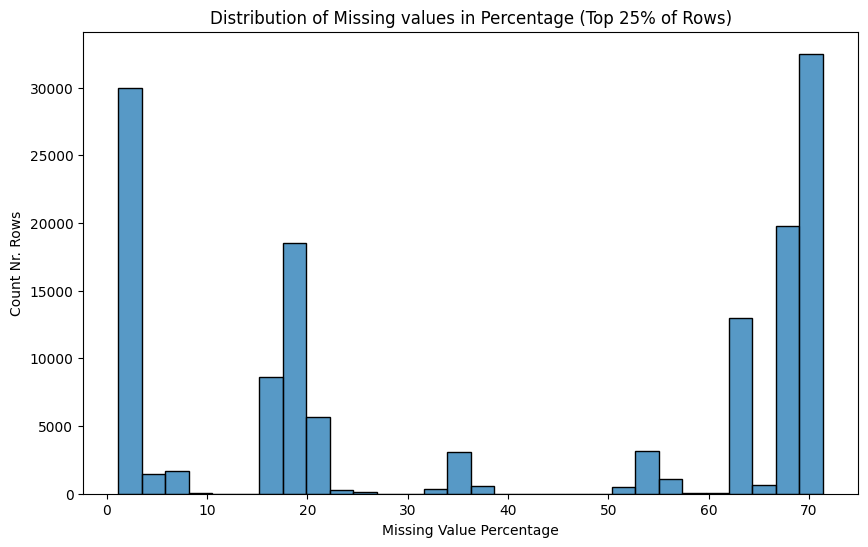

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(high_missing_rows , bins=30)
plt.title('Distribution of Missing values in Percentage (Top 25% of Rows)')
plt.xlabel('Missing Value Percentage')
plt.ylabel('Count Nr. Rows')
plt.show();

After our analysis of the q75 of missing values in rows, we can see that there is a big cluster of missing values starting from 63%. Therefore, it would make sense to drop rows with more than 60% of missing values to increase data quality. 


In [23]:
#Drop rows that have ≥60% missing data:
azdias_sample_cleaned_rows = azdias_sample_cleaned.drop(index=high_missing_rows[high_missing_rows >= 60].index)
azdias_sample_cleaned_rows.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [24]:
#Now test if the dropped rows worked succesfully
nan_rows_cleaned = azdias_sample_cleaned_rows.isna().sum(axis=1)
missing_rows_percentage_cleaned = (nan_rows_cleaned/ azdias_sample_cleaned_rows.shape[1])*100
missing_rows_percentage_cleaned.describe()

count    559127.000000
mean          2.005282
std           7.177004
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.826590
dtype: float64

**2.3. Handling dtypes**

In [25]:
#Rename the cleaned dataset, to mame it easier to work
azdias_sample_1 = azdias_sample_cleaned_rows 

In [26]:
# Summary of data types
azdias_sample_1.dtypes.value_counts()

float64    254
int64       87
object       5
Name: count, dtype: int64

**2.3.1. Object dtypes**

In [27]:
#Let´s start with the object dtypes: 
azdias_sample_1.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,1992-02-10 00:00:00,W
2,4C,4,24,1992-02-12 00:00:00,W
3,2A,2,12,1997-04-21 00:00:00,W
4,6B,6,43,1992-02-12 00:00:00,W
5,8C,8,54,1992-02-12 00:00:00,W


In [28]:
#We now check for NaN values: 
azdias_sample_1.select_dtypes(include='object').isnull().sum()

CAMEO_DEU_2015     4013
CAMEO_DEUG_2015    4013
CAMEO_INTL_2015    4013
EINGEFUEGT_AM         0
OST_WEST_KZ           0
dtype: int64

In [29]:
#Let´s impute the CAMEO NaN values with the mode: 
for col in ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
    mode_value = azdias_sample_1[col].mode()[0]
    azdias_sample_1[col] = azdias_sample_1[col].fillna(mode_value)
    
#We now check for NaN values: 
azdias_sample_1.select_dtypes(include='object').isnull().sum()

CAMEO_DEU_2015     0
CAMEO_DEUG_2015    0
CAMEO_INTL_2015    0
EINGEFUEGT_AM      0
OST_WEST_KZ        0
dtype: int64

In [30]:
#Change 'EINGEFUEGT_AM' to datetime, extract YEAR and rename the column_
azdias_sample_1 = pd.concat([
    azdias_sample_1, 
    pd.to_datetime(azdias_sample_1['EINGEFUEGT_AM'], errors='coerce').dt.year.rename('JAHR_EINGEFUEGT_AM')
], axis=1)

In [31]:
#Test changes
azdias_sample_1['JAHR_EINGEFUEGT_AM'].head()

1    1992
2    1992
3    1997
4    1992
5    1992
Name: JAHR_EINGEFUEGT_AM, dtype: int32

In [32]:
azdias_sample_1 = azdias_sample_1.drop(columns='EINGEFUEGT_AM')

In [33]:
# Test imputing process
azdias_sample_1.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 559127 entries, 1 to 624999
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEU_2015   559127 non-null  object
 1   CAMEO_DEUG_2015  559127 non-null  object
 2   CAMEO_INTL_2015  559127 non-null  object
 3   OST_WEST_KZ      559127 non-null  object
dtypes: object(4)
memory usage: 21.3+ MB


**2.3.2. Numerical dtypes**

In [34]:
nan_columns = azdias_sample_1.columns[azdias_sample_1.isnull().any()]
list(nan_columns)

['ANZ_HH_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'EWDICHTE',
 'FIRMENDICHTE',
 'GEBAEUDETYP_RASTER',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'HEALTH_TYP',
 'HH_DELTA_FLAG',
 'INNENSTADT',
 'KBA05_ALTER1',
 'KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_AUTOQUOT',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_GBZ',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3',
 'KBA05_HERST4',
 'KBA05_HERST5',
 'KBA05_HERSTTEMP',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_KRSKLEIN',
 'KBA05_KRSOBER',
 'KBA05_KRSVAN',
 'KBA05_KRSZUL',
 'KBA05_KW1',
 'KBA05_KW2',
 'KBA05_KW3',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA05_MOD1',
 'KBA05_MOD2',
 'KBA05_MOD

In [35]:
nan_summary = azdias_sample_1[nan_columns].isnull().sum().sort_values(ascending=False)
nan_summary.head(50)

KKK                45076
REGIOTYP           45076
W_KEIT_KIND_HH     41402
KBA05_AUTOQUOT     37962
KBA05_ALTER2       37958
KBA05_HERST2       37958
KBA05_HERST3       37958
KBA05_HERST4       37958
KBA05_ALTER4       37958
KBA05_CCM4         37958
KBA05_FRAU         37958
KBA05_DIESEL       37958
KBA05_KRSHERST1    37958
KBA05_KRSAQUOT     37958
KBA05_CCM1         37958
KBA05_HERST5       37958
KBA05_CCM3         37958
KBA05_CCM2         37958
KBA05_SEG4         37958
KBA05_SEG7         37958
KBA05_SEG3         37958
KBA05_SEG2         37958
KBA05_SEG10        37958
KBA05_SEG1         37958
KBA05_MOTOR        37958
KBA05_MOD8         37958
KBA05_MOD4         37958
KBA05_MOD3         37958
KBA05_MOD2         37958
KBA05_MOD1         37958
KBA05_MAXVORB      37958
KBA05_MAXSEG       37958
KBA05_MAXHERST     37958
KBA05_MAXBJ        37958
KBA05_MAXAH        37958
KBA05_KW3          37958
KBA05_KW2          37958
KBA05_KW1          37958
KBA05_KRSZUL       37958
KBA05_KRSVAN       37958


In [36]:
#Fill NaN with median values
azdias_sample_1.fillna(azdias_sample_1.median(numeric_only=True), inplace=True)
print(azdias_sample_1.isnull().sum().sum())

0


**2.4. Transform data**

In preparation for machine learning, we will now transform the cleaned data: 

In [37]:
azdias_new = azdias_sample_1
azdias_new.dtypes.value_counts()

float64    254
int64       87
object       4
int32        1
Name: count, dtype: int64

In [38]:
azdias_new.shape

(559127, 346)

**2.4.1 Transform Categorical Data**

We will user OneHotEncoding, to avoid high cardinality:

In [39]:
#1. Get object columns 
categorical_columns_azdias = azdias_new.select_dtypes(include='object').columns
categorical_columns_azdias

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ'], dtype='object')

In [40]:
#2. check the number of unique values - the cardinality
azdias_new[categorical_columns_azdias].nunique().sort_values()

OST_WEST_KZ         2
CAMEO_DEUG_2015    10
CAMEO_INTL_2015    22
CAMEO_DEU_2015     45
dtype: int64

What we are seeing here is: 

- 2 categories - can be converted to binary (0/1)

- low cardinality - less than 10 unique values - we use OneHotEncoding

- high cardinality - separate analysis necessary

In [41]:
#3. transform 2 value categories to binary - OST_WEST_KZ
binary_columns = [col for col in categorical_columns_azdias if azdias_new[col].nunique() == 2]

for col in binary_columns:
    azdias_new[col] = azdias_new[col].astype('category').cat.codes

binary_columns

['OST_WEST_KZ']

In [42]:
#Use OneHotEncoder for low-cardinality features 
one_hot_cols = [col for col in categorical_columns_azdias if azdias_new[col].nunique() > 2 and azdias_new[col].nunique() < 11]

azdias_new = pd.get_dummies(azdias_new, columns=one_hot_cols, drop_first=True)

In [43]:
#In our case, we will drop the high cardinality variables. The reason is the size of the dataset is really high and these would increase extensively
cat_columns_to_drop = [col for col in categorical_columns_azdias if col in azdias_new.columns and azdias_new[col].nunique() >= 11]
azdias_new = azdias_new.drop(columns=cat_columns_to_drop)

In [44]:
azdias_new.dtypes.value_counts()

float64    254
int64       87
bool         9
int8         1
int32        1
Name: count, dtype: int64

In [45]:
azdias_new.dtypes[azdias_new.dtypes == 'int8']

OST_WEST_KZ    int8
dtype: object

In [46]:
azdias_new['OST_WEST_KZ'].unique()

array([1, 0], dtype=int8)

All object dtypes have been transformed to numerical, which means that these are not encoded.

**2.4.2. Transform Numerical Data**

Since I am working on demographic data, it makes sense to user Standard Scaling for the Z-Score Normalization: 

In [47]:
azdias_new.dtypes.value_counts()

float64    254
int64       87
bool         9
int8         1
int32        1
Name: count, dtype: int64

In [48]:
# Before transforming the numerical data, let´s deal with the bool columns:
bool_columns = azdias_new.select_dtypes(include='bool').columns
azdias_new[bool_columns] = azdias_new[bool_columns].astype(int)
azdias_new.dtypes.value_counts()

float64    254
int64       96
int8         1
int32        1
Name: count, dtype: int64

In [49]:
#Due to the fact that our dataset is large, we will try scaling the data for a sample of the dataset: 
# 1. Create numerical columns 
sample = azdias_new.head(100).copy()

# 2. Select the numerical columns 
numerical_columns = sample.select_dtypes(include=[np.number]).columns

In [50]:
# 3. Reduce memory usage before scaling
sample.loc[:, numerical_columns] = sample[numerical_columns].astype('float32')

In [51]:
# 4. Create a sample of the dataframe that we are going to fit 
azdias_fit_sample = azdias_new.sample(n=200000, random_state=42)
azdias_fit_sample[numerical_columns] = azdias_fit_sample[numerical_columns].astype('float32')

In [52]:
# 5. Fit scaler on sample
scaler = StandardScaler()
scaler.fit(azdias_fit_sample[numerical_columns].sample(n=10000, random_state=42))

StandardScaler()

In [53]:
# 6. Scale in chunks
chunk_size = 50000
azdias_scaled = azdias_fit_sample.copy()

for start_row in range(0, azdias_scaled.shape[0], chunk_size):
    end_row = min(start_row + chunk_size, azdias_scaled.shape[0])
    chunk = azdias_scaled.iloc[start_row:end_row].copy()

    scaled_chunk = scaler.transform(chunk[numerical_columns])
    
    # Use iloc with get_indexer to assign to correct columns by position
    azdias_scaled.iloc[start_row:end_row, azdias_scaled.columns.get_indexer(numerical_columns)] = scaled_chunk

In [54]:
azdias_scaled.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,JAHR_EINGEFUEGT_AM,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X
4482,-0.081234,-0.114162,-0.388520,-0.118011,3.679896,0.256373,-0.367988,-0.053837,-0.164504,0.847019,...,0.552599,-0.331293,-0.349583,-0.392345,-0.278543,-0.383474,-0.334998,-0.467728,2.562088,-0.020004
354025,0.724370,1.253707,0.337935,-0.118011,-0.302891,0.256373,0.399026,-0.053837,-1.170032,0.847019,...,0.304863,-0.331293,-0.349583,2.548774,-0.278543,-0.383474,-0.334998,-0.467728,-0.390307,-0.020004
411376,1.531982,0.432985,-0.206906,-0.118011,-0.302891,-0.626453,-0.176234,-0.053837,-1.170032,0.847019,...,-0.438343,-0.331293,2.860548,-0.392345,-0.278543,-0.383474,-0.334998,-0.467728,-0.390307,-0.020004
347878,-1.451867,-0.661310,-0.449058,-0.118011,-0.302891,-0.626453,-0.431905,-0.053837,0.841024,1.306831,...,0.304863,-0.331293,-0.349583,-0.392345,-0.278543,2.607741,-0.334998,-0.467728,-0.390307,-0.020004
613767,1.037384,0.706559,0.822238,-0.118011,-0.302891,-0.626453,0.462944,-0.053837,-0.164504,0.847019,...,-0.438343,-0.331293,-0.349583,-0.392345,-0.278543,-0.383474,-0.334998,-0.467728,2.562088,-0.020004


In [55]:
azdias_scaled.shape

(200000, 352)

In [56]:
azdias_scaled.dtypes.value_counts()

float32    352
Name: count, dtype: int64

**3. Now that AZDIAS dataset is clean and transformed, We will working on the CUSTOMERS dataset:**

**3.1. Handle missing values in columns for customers**

As we analyzed the NaN values for azdias, we are going to drop the same columns:

In [57]:
# 1st let´s check on the columns that are different between both datasets. 
#We know that there are three columns that customers have, plus the ones we deleted from azdias:
print(azdias_sample_1.shape)
print(customers.shape)
set(azdias_sample_1.columns) ^ set(customers.columns)

(559127, 346)
(191652, 369)


{'AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CUSTOMER_GROUP',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EINGEFUEGT_AM',
 'EXTSEL992',
 'JAHR_EINGEFUEGT_AM',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP',
 'TITEL_KZ'}

In [58]:
# We got the columns, let´s drop them: 
customers_1 = customers.drop(['AGER_TYP', 'ALTERSKATEGORIE_FEIN', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
                            'ALTER_KIND4', 'CUSTOMER_GROUP', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
                            'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12',
                            'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP',
                            'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'TITEL_KZ'], axis=1)
customers_1.shape

(191652, 346)

In [59]:
#Use the created mapping drom DIAS_Attributes to replace values to NaN: 
for attribute in nan_values['Attribute'].dropna().unique():
    if attribute in customers_1.columns: 
        # get all the values to replace for each attribute:
        values = nan_values[nan_values['Attribute'] == attribute]['Value']
        
        #flatten, split by coma, strip white spaces and convert to numeric if needed
        replace_vals = pd.Series(','.join(values.dropna().astype(str)).split(',')).str.strip()
        
        #Convert to numeric if the column is numeric:
        if pd.api.types.is_numeric_dtype(customers_1[attribute]):
            replace_vals = pd.to_numeric(replace_vals, errors='coerce')
        
        #replace in the azdias_sample
        customers_1[attribute] = customers_1[attribute].replace(replace_vals.tolist(), np.nan)   

In [60]:
customers_1.head(10)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,9.0,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3,1,4
2,143872,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3
6,143904,1.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,6.0,...,4.0,3.0,4.0,2.0,6.0,9.0,7.0,1,1,4
7,143910,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,5.0,...,3.0,1.0,2.0,1.0,6.0,9.0,3.0,3,1,4
8,102160,3.0,74.0,2.0,0.0,1.0,82.0,0.0,3.0,3.0,...,NaN,8.0,11.0,9.0,6.0,3.0,4.0,3,2,4
9,102173,1.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,5.0,1,1,3


In [61]:
#Let´s check on the highest percentage of missing data:
nan_percent_customers = customers_1.isna().mean().sort_values(ascending=False) * 100
nan_percent_customers.head(20)

KKK               31.340137
REGIOTYP          31.340137
W_KEIT_KIND_HH    29.708534
KBA05_AUTOQUOT    29.696533
KBA05_DIESEL      29.696012
KBA05_FRAU        29.696012
KBA05_VORB0       29.696012
KBA05_KRSKLEIN    29.696012
KBA05_MOD4        29.696012
KBA05_MOD1        29.696012
KBA05_SEG2        29.696012
KBA05_SEG10       29.696012
KBA05_MAXHERST    29.696012
KBA05_SEG4        29.696012
KBA05_HERST1      29.696012
KBA05_CCM4        29.696012
KBA05_MAXAH       29.696012
KBA05_KW1         29.696012
KBA05_KW2         29.696012
KBA05_KW3         29.696012
dtype: float64

In [62]:
# let´s have run sume statistics on the NaN values
nan_percent_customers.describe()

count    346.000000
mean      19.004481
std       12.599353
min        0.000000
25%        0.387160
50%       26.757352
75%       26.757352
max       31.340137
dtype: float64

In [63]:
#Based on the statistics on customers_nan_percent, let´s create the necessary bins:
bins = [0, 1, 10, 20, 26, 30, 40, 75, 100]
labels = ['0%', '1-10%', '10-20%', '20-25%', '25-30%', '30-40%', '40-75%', '>75%']

# Transform nan_percent series into these bins
customers_cols_percent_nan = pd.cut(nan_percent_customers, bins=bins, labels=labels, include_lowest=True)

# Count how many columns fall into each category
customers_count_cols = customers_cols_percent_nan.value_counts().sort_index()

print(customers_count_cols)

0%         87
1-10%      20
10-20%      0
20-25%     19
25-30%    218
30-40%      2
40-75%      0
>75%        0
Name: count, dtype: int64


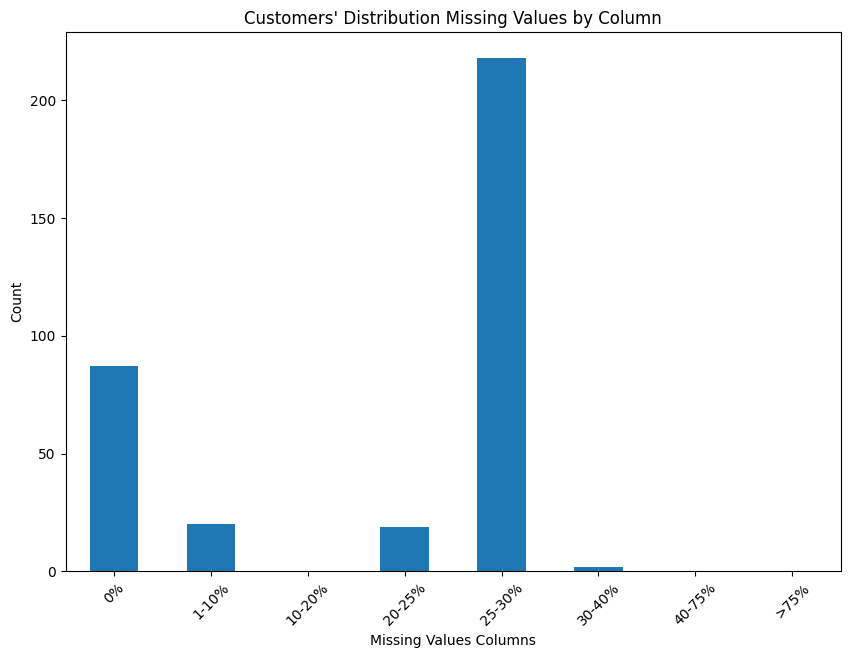

In [64]:
#Now let's visualize the results: 
plt.figure(figsize=(10, 7))
customers_count_cols.plot(kind='bar')
plt.title("Customers' Distribution Missing Values by Column")
plt.xlabel('Missing Values Columns')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show();

Thanks to the above findings, we can say that:

- The mean of missing values for the dataset is 19% 
- The max of missing values is 31.3%, a little higher as in the azdias dataset after cleaning the columns
- However, we can definitely infer that after deleting the same columns as we did for azdias, we already dealt with the main missing values. 
- We will tackle the rest of the missing values through: 
    -> dealing with NaN values in rows 
    -> NaN imputation

**3.2. Handling missing Values customers for rows**

In [65]:
# Check the rows with nan values and pull the statistics:
nan_rows_customers = customers_1.isna().sum(axis=1)
missing_rows_percentage_customers = (nan_rows_customers/ customers_1.shape[1])*100
missing_rows_percentage_customers.describe()

count    191652.000000
mean         19.004481
std          29.954292
min           0.000000
25%           0.000000
50%           0.000000
75%          63.583815
max          71.387283
dtype: float64

We see that 75% of the rows have only more than 63% missing values. This is pretty high. Now let´s pick up on those rows and see if we drop them or impute them:

In [66]:
# Set threshold (e.g., 60%)
threshold = 60

In [67]:
# Filter rows to drop
rows_to_drop = missing_rows_percentage_customers[missing_rows_percentage_customers > threshold].index

In [68]:
# Drop rows
customers_cleaned = customers_1.drop(index=rows_to_drop)
customers_cleaned.shape

(141717, 346)

In [69]:
#Now test if the dropped rows worked succesfully
nan_rows_customers_clean = customers_cleaned.isna().sum(axis=1)
missing_rows_percentage_customers_cleaned = (nan_rows_customers_clean/ customers_cleaned.shape[1])*100
missing_rows_percentage_customers_cleaned.describe()

count    141717.000000
mean          1.499467
std           6.057029
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          57.803468
dtype: float64

**3.3. Handling dtypes**

In [70]:
#Summary of dtypes 
customers_cleaned.dtypes.value_counts()

float64    254
int64       87
object       5
Name: count, dtype: int64

**3.3.1. Object dtypes**

In [71]:
#As we did with azdias, let´s start with the object dtypes: 
customers_cleaned.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
0,1A,1,13,1992-02-12 00:00:00,W
2,5D,5,34,1992-02-10 00:00:00,W
3,4C,4,24,1992-02-10 00:00:00,W
4,7B,7,41,1992-02-12 00:00:00,W
5,5D,5,34,1992-02-10 00:00:00,W


In [72]:
#We now check for NaN values: 
customers_cleaned.select_dtypes(include='object').isnull().sum()

CAMEO_DEU_2015     498
CAMEO_DEUG_2015    498
CAMEO_INTL_2015    498
EINGEFUEGT_AM        0
OST_WEST_KZ          0
dtype: int64

In [73]:
#Let´s impute the CAMEO NaN values with the mode, as we did for aszdias: 
for col in ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
    mode_value = customers_cleaned[col].mode()[0]
    customers_cleaned[col] = customers_cleaned[col].fillna(mode_value)
    
#We now check for NaN values: 
customers_cleaned.select_dtypes(include='object').isnull().sum()

CAMEO_DEU_2015     0
CAMEO_DEUG_2015    0
CAMEO_INTL_2015    0
EINGEFUEGT_AM      0
OST_WEST_KZ        0
dtype: int64

In [74]:
#Change 'EINGEFUEGT_AM' to datetime, extract year, change name of colum to year of addition:
customers_cleaned = pd.concat([
    customers_cleaned, 
    pd.to_datetime(customers_cleaned['EINGEFUEGT_AM'], errors='coerce').dt.year.rename('JAHR_EINGEFUEGT_AM')
], axis=1)

#Test changes
customers_cleaned['JAHR_EINGEFUEGT_AM'].head()

0    1992
2    1992
3    1992
4    1992
5    1992
Name: JAHR_EINGEFUEGT_AM, dtype: int32

In [75]:
customers_cleaned = customers_cleaned.drop(columns='EINGEFUEGT_AM')

In [76]:
# Test imputing process
customers_cleaned.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 141717 entries, 0 to 191651
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEU_2015   141717 non-null  object
 1   CAMEO_DEUG_2015  141717 non-null  object
 2   CAMEO_INTL_2015  141717 non-null  object
 3   OST_WEST_KZ      141717 non-null  object
dtypes: object(4)
memory usage: 5.4+ MB


**3.3.2. Numerical dtypes**

In [77]:
nan_columns_customers = customers_cleaned.columns[customers_cleaned.isnull().any()]
list(nan_columns_customers)

['ANZ_HH_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'EWDICHTE',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'HEALTH_TYP',
 'HH_DELTA_FLAG',
 'INNENSTADT',
 'KBA05_ALTER1',
 'KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_AUTOQUOT',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_GBZ',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3',
 'KBA05_HERST4',
 'KBA05_HERST5',
 'KBA05_HERSTTEMP',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_KRSKLEIN',
 'KBA05_KRSOBER',
 'KBA05_KRSVAN',
 'KBA05_KRSZUL',
 'KBA05_KW1',
 'KBA05_KW2',
 'KBA05_KW3',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA05_MOD1',
 'KBA05_MOD2',
 'KBA05_MOD3',
 'KBA05_MOD4',
 'KBA05_MOD8',
 'KBA0

In [78]:
nan_summary_customers = customers_cleaned[nan_columns_customers].isnull().sum().sort_values(ascending=False)
nan_summary_customers.head(30)

REGIOTYP          10132
KKK               10132
W_KEIT_KIND_HH     7939
HH_DELTA_FLAG      6996
KBA05_AUTOQUOT     6979
KBA05_ALTER3       6978
KBA05_HERST2       6978
KBA05_ALTER1       6978
KBA05_ALTER4       6978
KBA05_HERST5       6978
KBA05_HERST4       6978
KBA05_CCM4         6978
KBA05_DIESEL       6978
KBA05_CCM3         6978
KBA05_CCM2         6978
KBA05_CCM1         6978
KBA05_KRSAQUOT     6978
KBA05_FRAU         6978
KBA05_SEG10        6978
KBA05_SEG1         6978
KBA05_MOTOR        6978
KBA05_MOD8         6978
KBA05_MOD4         6978
KBA05_MOD3         6978
KBA05_MOD2         6978
KBA05_MOD1         6978
KBA05_MAXVORB      6978
KBA05_MAXSEG       6978
KBA05_MAXHERST     6978
KBA05_MAXBJ        6978
dtype: int64

In [79]:
#Fill NaN with median values
customers_cleaned.fillna(customers_cleaned.median(numeric_only=True), inplace=True)
print(customers_cleaned.isnull().sum().sum())

0


**3.4. Transform data**

In preparation for machine learning, we will now also transform the cleaned customers data:

In [80]:
customers_cleaned.dtypes.value_counts()

float64    254
int64       87
object       4
int32        1
Name: count, dtype: int64

In [81]:
customers_cleaned_1 = customers_cleaned.copy()

**3.4.1 Transform Categorical Data**

We will use OneHotEncoding, as we did for the AZDIAS dataset 

In [82]:
#1. Get object columns 
categorical_columns_customers = customers_cleaned_1.select_dtypes(include='object').columns
categorical_columns_customers


Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ'], dtype='object')

In [83]:
#2. check the number of unique values - the cardinality
customers_cleaned_1[categorical_columns_customers].nunique().sort_values()

OST_WEST_KZ         2
CAMEO_DEUG_2015    10
CAMEO_INTL_2015    22
CAMEO_DEU_2015     45
dtype: int64

In [84]:
#3. transform 2 value categories to binary - OST_WEST_KZ
binary_columns_customers = [col for col in categorical_columns_customers if customers_cleaned_1[col].nunique() == 2]
for col in binary_columns_customers:
    customers_cleaned_1[col] = customers_cleaned_1[col].astype('category').cat.codes
binary_columns_customers


['OST_WEST_KZ']

In [85]:
#4. Use OneHotEncoder for low-cardinality features 
one_hot_cols = [col for col in categorical_columns_customers if customers_cleaned_1[col].nunique() > 2 and customers_cleaned_1[col].nunique() < 11]
customers_cleaned_1 = pd.get_dummies(customers_cleaned_1, columns=one_hot_cols, drop_first=True)

In [86]:
#5. Drop high cardinality values
cat_columns_to_drop_customers = [col for col in categorical_columns_customers if col in customers_cleaned_1.columns and customers_cleaned_1[col].nunique() >= 11]
customers_cleaned_1= customers_cleaned_1.drop(columns=cat_columns_to_drop_customers)


In [87]:
customers_cleaned_1.dtypes.value_counts()

float64    254
int64       87
bool         9
int8         1
int32        1
Name: count, dtype: int64

**3.4.2. Transform Numerical Data**

We are using Standard Scaling for the Z-Score Normalization again: 

In [88]:

customers_cleaned_1.dtypes.value_counts()

float64    254
int64       87
bool         9
int8         1
int32        1
Name: count, dtype: int64

In [89]:
# Before transforming the numerical data, let´s deal with the bool columns:
bool_columns_customers = customers_cleaned_1.select_dtypes(include='bool').columns
customers_cleaned_1[bool_columns_customers] = customers_cleaned_1[bool_columns_customers].astype(int)
customers_cleaned_1.dtypes.value_counts()

float64    254
int64       96
int8         1
int32        1
Name: count, dtype: int64

In [90]:
numerical_columns_customers = customers_cleaned_1.select_dtypes(include=[np.number]).columns

In [91]:
# 5. Fit scaler on sample
scaler = StandardScaler()
scaler.fit(customers_cleaned_1[numerical_columns_customers])

StandardScaler()

In [92]:
# Transform directly (this returns a NumPy array)
scaled_array = scaler.transform(customers_cleaned_1[numerical_columns_customers])

# Put the scaled values back into a DataFrame
customers_scaled = customers_cleaned_1.copy()
customers_scaled[numerical_columns_customers] = scaled_array

In [93]:
customers_scaled.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,JAHR_EINGEFUEGT_AM,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X
0,-1.561181,-0.379513,-0.277133,-0.122598,-0.276245,-0.193377,-0.260946,-0.133726,-1.806514,-0.615735,...,-0.401317,-0.451326,-0.386155,-0.429407,-0.299491,-0.390091,-0.283707,-0.318459,-0.217335,-0.029712
2,0.864730,-0.379513,-0.277133,-0.122598,-0.276245,-0.912058,-0.260946,-0.133726,0.172673,1.276064,...,-0.401317,-0.451326,-0.386155,-0.429407,3.338998,-0.390091,-0.283707,-0.318459,-0.217335,-0.029712
3,0.864749,-0.379513,-0.347015,-0.122598,-0.276245,-1.630740,-0.260946,-0.133726,-1.806514,1.276064,...,-0.401317,-0.451326,-0.386155,2.328795,-0.299491,-0.390091,-0.283707,-0.318459,-0.217335,-0.029712
4,0.864767,-0.379513,0.142157,-0.122598,-0.276245,1.243986,0.162054,-0.133726,0.172673,-0.615735,...,-0.401317,-0.451326,-0.386155,-0.429407,-0.299491,-0.390091,3.524767,-0.318459,-0.217335,-0.029712
5,0.865020,-0.379513,-0.277133,-0.122598,-0.276245,-0.193377,-0.260946,-0.133726,0.172673,1.276064,...,-0.401317,-0.451326,-0.386155,-0.429407,3.338998,-0.390091,-0.283707,-0.318459,-0.217335,-0.029712


In [94]:
customers_scaled.dtypes.value_counts()

float64    352
Name: count, dtype: int64

In [95]:
customers_scaled = customers_scaled.astype(np.float32)
customers_scaled.dtypes.value_counts()

float32    352
Name: count, dtype: int64

**EDA and Data Processing Discussion:**

Following steps were followed to get explore, analyse, clean and transform the data:

- Identify Missing and Unknown Values
- Dropping Necessary Cols and Rows 
- Imputing NaN Vales based on DType:
    - Categorical - Mode
    - Numerical - Median
- Data Type Transformation:
    - Categorical - binary variables & OneHotEncoding for low cardinality variables
    - Numerical - StandardScaler()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**1. [Principal component analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)**

Our goal using PCA is to simplify our large and complex dataset, without loosing relevant information. 

**1.1. Visualize components**

In [96]:
# 1. Initialize PCA
pca = PCA()

# 2. Fit to azdias_scaled dataset
pca.fit(azdias_scaled[numerical_columns])

PCA()

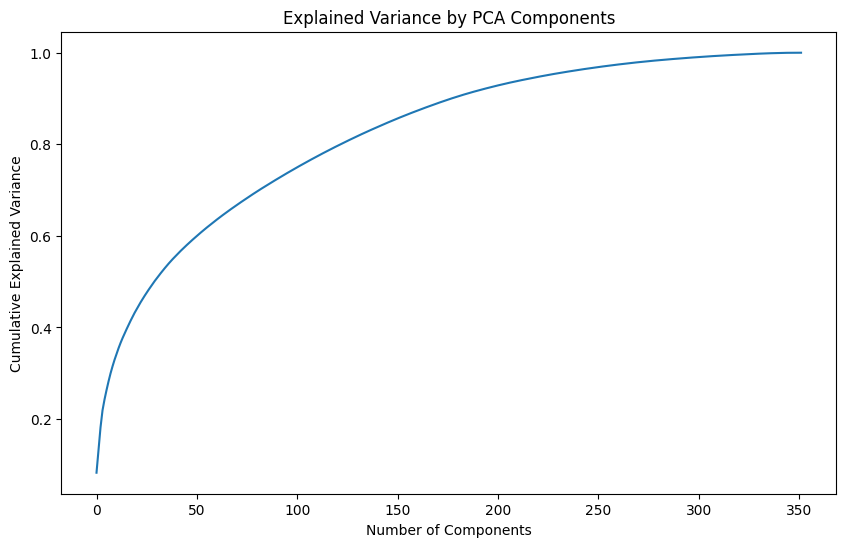

In [97]:
# 3. Visualize the components, to see which explain the most variance 
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show();

From this representation we see that the between 200 - 250 components, variance starts getting close to 95%. 

In [98]:
# 4. To understand which components we need to keep, we will compute them: 
components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_)> 0.95) +1
components_95

np.int64(225)

**1.2. Reduce dimensionality**

Based on our 95% variance, we will apply PCA:

In [99]:
pca_95 = PCA(n_components=225)
azdias_pca_95 = pca_95.fit_transform(azdias_scaled[numerical_columns])
azdias_pca_95 = pd.DataFrame(azdias_pca_95)
azdias_pca_95.shape

(200000, 225)

Now that azdias is fitted, transformed and the dimensionality is reduced, we are going to use the 95% variance to the customers_scaled dataset:

In [100]:
customers_pca_95 = pca_95.transform(customers_scaled[numerical_columns])
customers_pca_95 = pd.DataFrame(customers_pca_95)
customers_pca_95.shape

(141717, 225)

**2. [Elbow Method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)**

We use this technique to determine the optimal number of clusters in a dataset, with the help of K-means clustering algorithm.

In [101]:
# Define the range of clusters to test
range_clusters = range(1, 21)  
inertia = []

# Calculate K-Means for each number of clusters
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias_pca_95)  # Use the PCA-reduced data
    inertia.append(kmeans.inertia_)

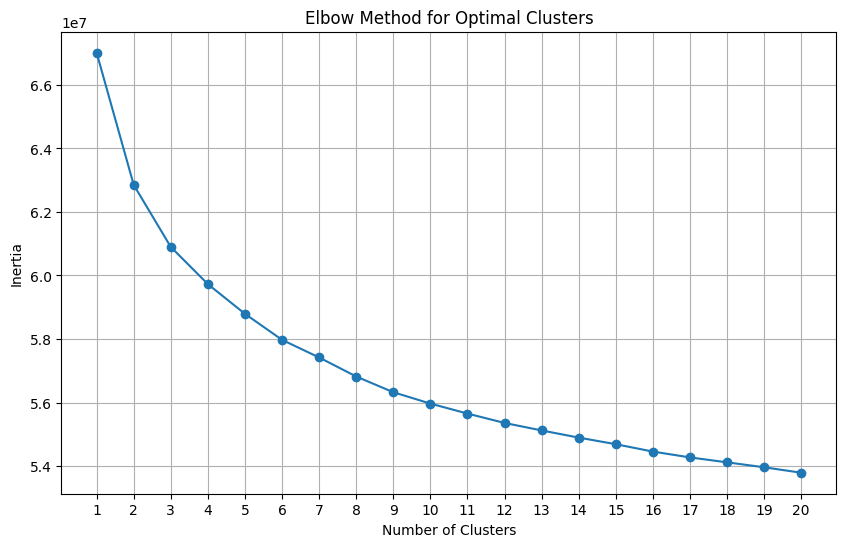

In [102]:
#Now let's visualize the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.xticks(range_clusters)
plt.grid(True)
plt.show();

Thanks to the grid in the visualization, we can identify that the decrease starts to be less sharp at 10 clusters. Now, we are going to use 10 as our n_clusters optimal number.

In [103]:
optimal_k =10

#Fit with the optimal clusters:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(azdias_pca_95)

# You can now add the cluster labels to your DataFrame
azdias_pca_95['Cluster'] = kmeans_final.labels_


In [104]:
# Check the distribution of clusters
azdias_pca_95['Cluster'].value_counts().sort_values(ascending=False)

Cluster
6    28176
5    27074
1    26746
8    25817
3    19737
2    17695
9    15700
0    13294
4    12961
7    12800
Name: count, dtype: int64

What we are seeing here are the different groups of population from the azdias_scaled and the values for each of the 219 principal components that we derived with 95% variance. 

In [105]:
#Let´s apply the optimal number of n_clusters to customers_pca_95 now:
optimal_k = 10

#Fit with the optimal clusters:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(customers_pca_95)

# You can now add the cluster labels to your DataFrame
customers_pca_95['Cluster'] = kmeans_final.labels_

# Check the distribution of clusters
customers_pca_95['Cluster'].value_counts().sort_values(ascending=False)


Cluster
4    21795
2    18462
8    17987
1    16046
3    14557
6    12156
9    12133
7    10751
5     9416
0     8414
Name: count, dtype: int64

**3. Cluster Understanding**

Now our goal is to understand what each cluster represent, so we can compare the German population and the customers. 

In [106]:
n_clusters = kmeans_final.n_clusters

#Inverse transform to get the original features
original_features = pca_95.inverse_transform(kmeans_final.cluster_centers_)

#Create a DataFrame of the original features
original_features_df = pd.DataFrame(original_features, columns=numerical_columns)
original_features_df['Clusters'] = range(n_clusters)
original_features_df.round(2)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,Clusters
0,-0.11,0.14,0.52,-0.02,-0.17,-0.42,0.51,-0.07,1.04,-0.33,...,-0.50,-0.41,-0.48,-0.26,0.05,0.10,0.97,0.53,-0.04,0
1,-0.00,-0.20,-0.24,-0.11,0.31,0.84,-0.24,-0.06,-0.66,0.71,...,0.16,0.23,0.44,0.01,-0.15,-0.12,-0.24,-0.17,-0.03,1
2,-0.01,-0.05,-0.23,-0.11,-0.24,-0.43,-0.22,-0.08,-0.66,0.64,...,0.11,0.18,0.34,0.00,-0.06,-0.07,-0.21,-0.15,-0.00,2
3,0.03,0.23,0.62,0.21,-0.27,-0.71,0.62,-0.07,0.17,-0.14,...,-0.39,-0.18,-0.30,-0.04,0.32,0.22,0.23,0.21,-0.00,3
4,0.00,-0.13,-0.25,-0.07,-0.19,-0.02,-0.24,0.04,-0.12,-0.03,...,0.35,0.02,-0.01,-0.07,-0.07,-0.12,-0.17,-0.13,0.02,4
5,0.01,0.31,1.00,0.44,-0.08,-0.44,0.94,0.03,0.59,-0.80,...,-0.50,-0.41,-0.49,0.12,-0.18,0.37,0.55,0.64,-0.02,5
6,0.01,0.33,-0.14,-0.08,0.96,-0.03,-0.15,-0.06,-0.08,0.02,...,0.05,0.14,0.11,0.01,-0.04,0.00,-0.11,-0.09,0.00,6
7,-0.00,-0.02,-0.10,0.11,-0.08,-0.05,-0.10,0.23,0.25,-0.72,...,0.01,-0.11,-0.21,0.46,-0.10,-0.10,-0.14,-0.09,0.01,7
8,0.02,-0.11,-0.22,-0.07,-0.17,0.06,-0.21,0.01,0.41,-0.13,...,-0.07,0.07,-0.01,-0.09,0.21,0.03,-0.04,-0.10,0.04,8
9,0.01,-0.18,-0.21,-0.06,0.20,1.09,-0.22,0.07,-0.06,-0.02,...,0.25,0.08,0.07,-0.03,-0.04,-0.09,-0.15,-0.13,-0.03,9


In [107]:
#Calculate the STD accross clusters
feature_std = original_features_df.drop(columns='Clusters').std().sort_values(ascending=False)
top_features = feature_std.head(10).index.tolist()
top_features

['KBA13_BAUMAX',
 'PLZ8_BAUMAX',
 'MOBI_REGIO',
 'LP_STATUS_FEIN',
 'KBA05_ANTG1',
 'LP_STATUS_GROB',
 'KBA13_ANTG4',
 'PLZ8_ANTG1',
 'KBA13_ANTG1',
 'PLZ8_ANTG4']

**4. Cluster Representation in Population & Customers**

In [108]:
# 1. Create cluster counts
azdias_counts = azdias_pca_95['Cluster'].value_counts().sort_index()
customers_counts = customers_pca_95['Cluster'].value_counts().sort_index()


In [109]:
# 2. Normalize
azdias_norm = azdias_counts/ azdias_counts.sum()
customers_norm = customers_counts/ customers_counts.sum()

In [110]:
#3. Create a DataFrame where we see the clusters for the German Population, Customers and the difference between them:
cluster_comparison = pd.DataFrame({
    'German Population %': azdias_norm, 
    'Customers %': customers_norm, 
    'Difference': customers_norm - azdias_norm
}).round(4) * 100

cluster_comparison.index.name = 'Cluster'
cluster_comparison.reset_index(inplace=True)
cluster_comparison.sort_values(by='Difference', ascending=False)

,Cluster,German Population %,Customers %,Difference
4,4,6.48,15.38,8.90
2,2,8.85,13.03,4.18
7,7,6.40,7.59,1.19
9,9,7.85,8.56,0.71
3,3,9.87,10.27,0.40
8,8,12.91,12.69,-0.22
0,0,6.65,5.94,-0.71
1,1,13.37,11.32,-2.05
6,6,14.09,8.58,-5.51
5,5,13.54,6.64,-6.89


In [111]:
# 4. Add original features
cluster_summary = pd.merge(cluster_comparison, original_features_df, left_on='Cluster', right_on='Clusters').drop(columns='Clusters')
cluster_summary

,Cluster,German Population %,Customers %,Difference,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,JAHR_EINGEFUEGT_AM,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X
0,0,6.65,5.94,-0.71,-0.112049,0.142813,0.523735,-0.021596,-0.174994,-0.415002,...,-0.177448,-0.495136,-0.407882,-0.479560,-0.260455,0.045823,0.101165,0.967653,0.526776,-0.036208
1,1,13.37,11.32,-2.05,-0.002541,-0.199776,-0.239711,-0.107352,0.311167,0.838623,...,0.100951,0.162030,0.225445,0.440180,0.012496,-0.152016,-0.116674,-0.237311,-0.165321,-0.026209
2,2,8.85,13.03,4.18,-0.008055,-0.052064,-0.229563,-0.106881,-0.244711,-0.429132,...,0.069595,0.110016,0.182939,0.344622,0.001208,-0.057143,-0.074348,-0.207753,-0.146961,-0.003563
3,3,9.87,10.27,0.40,0.029089,0.232706,0.622687,0.209229,-0.266972,-0.708382,...,-0.064776,-0.387817,-0.184741,-0.297027,-0.039401,0.316233,0.216663,0.232862,0.206409,-0.002737
4,4,6.48,15.38,8.90,0.001863,-0.133534,-0.246785,-0.066860,-0.190157,-0.016120,...,-0.178047,0.350678,0.019539,-0.007465,-0.070995,-0.071302,-0.119152,-0.171262,-0.127769,0.022524
5,5,13.54,6.64,-6.89,0.007004,0.309492,1.000326,0.443990,-0.080399,-0.439934,...,-0.217685,-0.504209,-0.414780,-0.487285,0.123158,-0.176218,0.367194,0.551514,0.641264,-0.024513
6,6,14.09,8.58,-5.51,0.013690,0.325853,-0.139317,-0.081971,0.963193,-0.026047,...,0.807906,0.046326,0.142324,0.113094,0.006037,-0.042247,0.002184,-0.109327,-0.087661,0.003984
7,7,6.40,7.59,1.19,-0.001580,-0.019547,-0.099521,0.106669,-0.079130,-0.046396,...,-0.187541,0.006065,-0.105132,-0.213936,0.456915,-0.100669,-0.095127,-0.137430,-0.091448,0.011768
8,8,12.91,12.69,-0.22,0.017907,-0.113683,-0.215412,-0.074317,-0.174361,0.062771,...,-0.123215,-0.070738,0.065316,-0.007916,-0.090469,0.214360,0.026719,-0.043812,-0.102262,0.039449
9,9,7.85,8.56,0.71,0.006016,-0.181390,-0.214627,-0.062558,0.195393,1.093294,...,-0.057729,0.253384,0.076265,0.067100,-0.031659,-0.040450,-0.091064,-0.146150,-0.130466,-0.025119


In [112]:
#5. Select top_features only
features_to_keep = ['Cluster', 'German Population %', 'Customers %', 'Difference'] + top_features
cluster_summary_top_features = cluster_summary[features_to_keep]
cluster_summary_top_features.round(2).sort_values(by='Difference', ascending=False)

,Cluster,German Population %,Customers %,Difference,KBA13_BAUMAX,PLZ8_BAUMAX,MOBI_REGIO,LP_STATUS_FEIN,KBA05_ANTG1,LP_STATUS_GROB,KBA13_ANTG4,PLZ8_ANTG1,KBA13_ANTG1,PLZ8_ANTG4
4,4,6.48,15.38,8.90,-0.41,-0.41,0.52,0.58,0.59,0.62,-0.22,0.43,0.42,-0.23
2,2,8.85,13.03,4.18,-0.48,-0.45,0.51,0.38,0.44,0.30,-0.65,0.59,0.61,-0.64
7,7,6.40,7.59,1.19,0.08,0.05,-0.02,0.11,0.01,0.19,0.07,-0.09,-0.10,0.04
9,9,7.85,8.56,0.71,-0.30,-0.30,0.38,0.44,0.39,0.46,-0.18,0.20,0.18,-0.17
3,3,9.87,10.27,0.40,0.12,0.08,-1.07,-1.23,-1.04,-1.20,0.35,-0.38,-0.38,0.34
8,8,12.91,12.69,-0.22,-0.16,-0.18,0.25,0.44,0.32,0.48,0.05,-0.09,-0.10,0.05
0,0,6.65,5.94,-0.71,1.35,1.32,-1.35,-1.42,-1.42,-1.39,1.21,-1.37,-1.36,1.16
1,1,13.37,11.32,-2.05,-0.48,-0.44,0.64,0.47,0.51,0.37,-0.71,0.66,0.68,-0.70
6,6,14.09,8.58,-5.51,-0.29,-0.30,0.12,0.03,0.01,-0.04,-0.25,0.10,0.12,-0.22
5,5,13.54,6.64,-6.89,2.31,2.32,-1.55,-1.35,-1.42,-1.29,1.76,-1.64,-1.60,1.74


We are now able to see the clusters in which the customers are overrepresentend (difference is positive) and underrepresented (difference is negative).

**5. Visualization and Discussion**

In order to get a better understanding, let´s visualize our outcome:

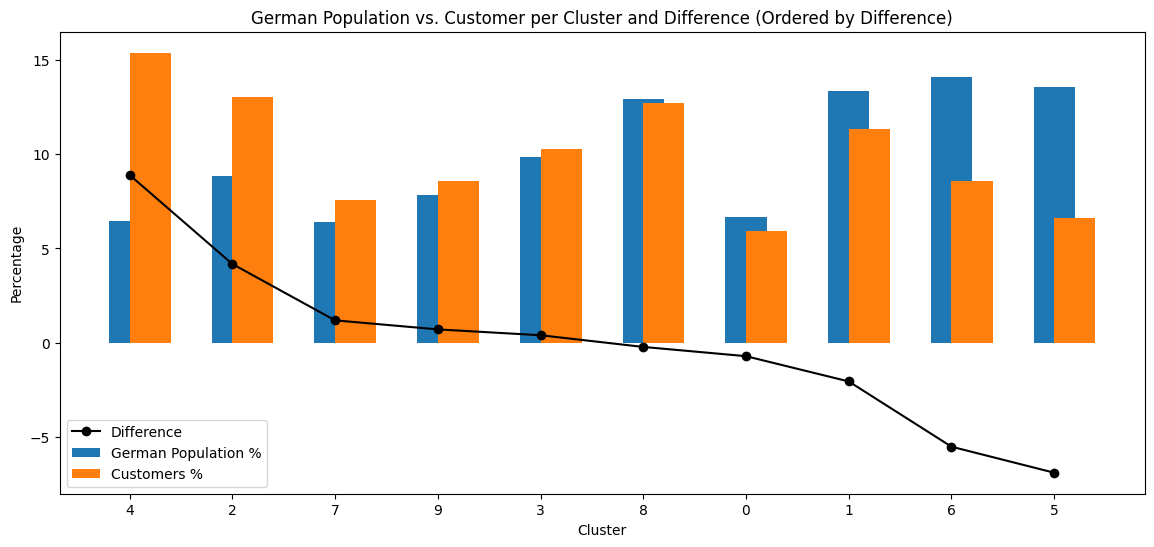

In [113]:
# Sort the DataFrame by 'Difference' in descending order
cluster_summary_top_features_sorted = cluster_summary_top_features.sort_values(by='Difference', ascending=False)

plt.figure(figsize=(14, 6))

# Define clusters from the sorted DataFrame
clusters = cluster_summary_top_features_sorted['Cluster'].astype(str)
x = range(len(clusters))

# Create bar plots
plt.bar(x, cluster_summary_top_features_sorted['German Population %'], 
        label='German Population %', width=0.4, align='center')

plt.bar(x, cluster_summary_top_features_sorted['Customers %'],
        label='Customers %', width=0.4, align='edge')

# Plot the difference
plt.plot(x, cluster_summary_top_features_sorted['Difference'],
         label='Difference', color='black', marker='o')

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('German Population vs. Customer per Cluster and Difference (Ordered by Difference)')
plt.xticks(ticks=x, labels=clusters)
plt.legend()
plt.show()



**Discussion**

Based on our results, we can see the following clusters:

- **Customers are overepresented** in clusters 4, 2, 7, 9, 3. These have the following overlapped feature characteristics:

**-> KBA13_BAUMAX, KBA13_ANTG4, KBA13_ANTG1**: though we do not have a descritpion in DIAS_Attibutes towards this features, we know that these are related to the car ownership. Here, you can find more information about [KBA](https://www.kba.de/DE/Themen/Typgenehmigung/Zum_Herunterladen/Benennung_Technischer_Dienst/benennungsregeln_TD_C.pdf?__blob=publicationFile&v=2). 

**-> MOBI_REGIO**: we see that customers have increased moving patters, compared to the general German population. 

**-> LP_STATUS_FEIN, LP_STATUS_GROB**: we see that the fine and rough social status of the customers tend to be higher compared to the characteristics for the population dataset. 

**-> PLZ8_BAUMAX, KBA05_ANTG1, PLZ8_ANTG1, PLZ8_ANTG4**: Based on these features we see that customers tend to live in buildings or unit cells that are more likely to be 1-2 family houses than >10 family houses. 

- **Customers are underrepresented** in clusters 8, 0, 1, 6, 5 which also exhibit common feature characteristics:

**-> KBA13_BAUMAX, KBA13_ANTG4, KBA13_ANTG1**:  as explained aboe, these features do no have a direct description in our documentation, but we know that this is related to car ownership. The features for both customers and general population teng do be similar, except for KBA13_ANTG1, where customers have positive weighted points in contraposition to the general population. 

**-> MOBI_REGIO**: however, these clusters of population have decreased moving patters.

**-> LP_STATUS_FEIN, LP_STATUS_GROB**: overall we can see that fine social status is slightly lower for the genenral German population compared to customers. In the case of the rough social status, we see that the contraposition is higher, having the general population a lower rough social status. 

**-> PLZ8_BAUMAX, KBA05_ANTG1, PLZ8_ANTG1, PLZ8_ANTG4**:*: in contraposition to the clusters where customers were overrepresented, we see that the general German population tend to live in buildings or unit cells where the number of family houses are more likely to >10. 


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

**1. Load both datasets and have a first inspection**

In [114]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [115]:
mailout_train.shape

(42962, 367)

In [116]:
mailout_train['RESPONSE'].value_counts()

RESPONSE
0    42430
1      532
Name: count, dtype: int64

In [117]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [118]:
mailout_test.shape

(42833, 366)

**2. Create a cleaning function**

In [119]:
#Create a function that will help us clean the mailout_train and mailout_test dataframes, as we did with azdias and customers:
def cleaning_data(df):
    """
    Cleans the dataset: 
    - Uses DIAS_Attributes as a mapping to replace specific values with NaN
    - Drops columns that are >= threshold NaN
    - Drops rows that are >= threshold NaN
    Returns partially cleaned dataset
    """

    
    #Create a df copy 
    df_copy = df.copy()
    
    #Use nan_values as a mapping to replace the values in the dataset to NaN
    for attribute in nan_values['Attribute'].dropna().unique():
        if attribute in df.columns:
            # get all the values to replace for each attribute:
            values = nan_values[nan_values['Attribute'] == attribute]['Value']

            #flatten, split by coma, strip white spaces and convert to numeric if needed
            replace_vals = pd.Series(','.join(values.dropna().astype(str)).split(',')).str.strip()
            
            #Convert to numeric if the column is numeric:
            if pd.api.types.is_numeric_dtype(df[attribute]):
                replace_vals = pd.to_numeric(replace_vals, errors='coerce')
                
            #replace in the dataset
            df[attribute] = df[attribute].replace(replace_vals.tolist(), np.nan)
    
    #Calculate the % of NaN of dataset columns and drop cols with >= 20% missing values
    nan_percent_cols = df.isna().mean()
    threshold_cols = 0.2
    cols_to_drop = nan_percent_cols[nan_percent_cols >= threshold_cols].index
    df = df.drop(columns=cols_to_drop)

    print("Dropped {} columns due to >=20% missing values.".format(len(cols_to_drop)))

    #Calculate the % of NaN of dataset rows and drop rows with >=60% missing values
    nan_percent_rows = df.isna().sum(axis=1)
    nan_row_percentage = (nan_percent_rows / df.shape[1])*100
    threshold_rows = 60
    rows_to_drop = nan_row_percentage[nan_row_percentage >= threshold_rows].index
    df = df.drop(index=rows_to_drop)

    print("Dropped {} rows due to >=60% missing values.".format(len(rows_to_drop)))
    
    return df    

In [120]:
#Create a function that will help us impute categorical and numerical values
def impute_missing_values(df):
    """
    Imputes NaN Values:
    - selects dtype object and category and impute NaN with mode
    - selects numberical dtypes and imputes NaN with median
    Returns imputed dataframe
    """

    df_copy = df.copy()

    #select the object and category dtypes and replace NaN with mode
    for col in df.select_dtypes(include=['object', 'category']).columns: 
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
    
    #select numerical values and replace NaN with median
    for col in df.select_dtypes(include=['float', 'int']).columns: 
        if df[col].isnull().sum() > 0: 
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)
    
    return df

In [121]:
def transform_column_to_year(df, column_name):
    """
    - Transforms a specified column in the DataFrame to datetime,
    - extracts the year, and drops the original column.

    Returns:
    pd.DataFrame: The DataFrame with the new year column added and the original column dropped.
    """
    # Make a copy
    df_copy = df.copy()
    
    # Convert the specified column to datetime and extract the year
    year_column = pd.to_datetime(df[column_name], errors='coerce').dt.year.rename(f'JAHR_{column_name}')
    
    # Concatenate the new year column to the original DataFrame
    df = pd.concat([df, year_column], axis=1)

    # Drop the original column
    df = df.drop(columns=[column_name])
    
    return df

**3. Cleaning, Imputing & adjusting dtypes**:

In [122]:
# Let´s apply the above described function on the mailout_train dataframe:

mailout_train_cleaned = cleaning_data(mailout_train)
mailout_train_cleaned

Dropped 77 columns due to >=20% missing values.
Dropped 6987 rows due to >=60% missing values.


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3,0,2,4
1,1771,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,2,3
2,1776,1.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3,0,1,4
3,1460,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3,0,2,4
4,1783,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,1.0,10.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,...,3.0,1.0,1.0,1.0,8.0,7.0,1,0,1,4
42958,67629,1.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,4.0,...,3.0,1.0,1.0,1.0,9.0,7.0,1,0,1,3
42959,68273,1.0,10.0,2.0,0.0,0.0,3.0,2.0,0.0,1.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,1,4
42960,68581,1.0,13.0,3.0,0.0,0.0,3.0,2.0,0.0,2.0,...,3.0,2.0,3.0,4.0,9.0,2.0,3,0,2,4


In [123]:
mailout_train_imputed = impute_missing_values(mailout_train_cleaned)
mailout_train_imputed

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3,0,2,4
1,1771,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,2,3
2,1776,1.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3,0,1,4
3,1460,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3,0,2,4
4,1783,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,1.0,10.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,...,3.0,1.0,1.0,1.0,8.0,7.0,1,0,1,4
42958,67629,1.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,4.0,...,3.0,1.0,1.0,1.0,9.0,7.0,1,0,1,3
42959,68273,1.0,10.0,2.0,0.0,0.0,3.0,2.0,0.0,1.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,1,4
42960,68581,1.0,13.0,3.0,0.0,0.0,3.0,2.0,0.0,2.0,...,3.0,2.0,3.0,4.0,9.0,2.0,3,0,2,4


In [124]:
mailout_train_year = transform_column_to_year(mailout_train_imputed, 'EINGEFUEGT_AM')
mailout_train_year

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,JAHR_EINGEFUEGT_AM
0,1763,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,5.0,2.0,1.0,9.0,3.0,3,0,2,4,1992
1,1771,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,1.0,2.0,1.0,9.0,7.0,1,0,2,3,1997
2,1776,1.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,...,6.0,4.0,2.0,9.0,2.0,3,0,1,4,1995
3,1460,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,8.0,11.0,11.0,9.0,1.0,3,0,2,4,1992
4,1783,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,2.0,2.0,1.0,9.0,3.0,3,0,1,3,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,1.0,10.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,...,1.0,1.0,1.0,8.0,7.0,1,0,1,4,1992
42958,67629,1.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,4.0,...,1.0,1.0,1.0,9.0,7.0,1,0,1,3,1992
42959,68273,1.0,10.0,2.0,0.0,0.0,3.0,2.0,0.0,1.0,...,1.0,2.0,1.0,9.0,7.0,1,0,1,4,1992
42960,68581,1.0,13.0,3.0,0.0,0.0,3.0,2.0,0.0,2.0,...,2.0,3.0,4.0,9.0,2.0,3,0,2,4,1992


In [125]:
mailout_train_year.shape

(35975, 290)

In [126]:
mailout_train_year.isnull().sum().sum()

np.int64(0)

In [127]:
mailout_train_year.dtypes.value_counts()

float64    196
int64       88
object       5
int32        1
Name: count, dtype: int64

In [128]:
set(azdias_sample_1.columns) ^ set(mailout_train_year.columns)

{'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'HH_DELTA_FLAG',
 'KBA05_ALTER1',
 'KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_AUTOQUOT',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_GBZ',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3',
 'KBA05_HERST4',
 'KBA05_HERST5',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_KRSKLEIN',
 'KBA05_KRSOBER',
 'KBA05_KRSVAN',
 'KBA05_KRSZUL',
 'KBA05_KW1',
 'KBA05_KW2',
 'KBA05_KW3',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA05_MOD1',
 'KBA05_MOD2',
 'KBA05_MOD3',
 'KBA05_MOD4',
 'KBA05_MOD8',
 'KBA05_MOTOR

**4. Transforming Categorical and Numerical Data to Features**:

**4.1. Create functions**

In [129]:
#Create a function that takes the categorical columns, check the binary, low and high-cardinal variables and handles them accordingly: 
def transform_categorical_features(df):
    """  
    Transforms categorical columns:  
    - df Categorical Columns 
    - Two value columns are transformed to binary 
    - Low-cardinality columns are transformed with OneHotEncoding
    - High-Cardingality columns are dropped 
    
    Returns transformed dataframe
    """
    df_transformed = df.copy()

    # 1. Get object columns 
    categorical_columns = df_transformed.select_dtypes(include='object').columns

    # 2. Transform 2 value categories to binary 
    binary_columns = [col for col in categorical_columns if df_transformed[col].nunique() == 2]
    for col in binary_columns:
        df_transformed[col] = df_transformed[col].astype('category').cat.codes

    #3. Use OneHotEncoder for low-cardinality features 
    one_hot_cols = [col for col in categorical_columns if 2 < df[col].nunique() < 11 and col not in binary_columns]
    df_transformed = pd.get_dummies(df_transformed, columns=one_hot_cols, drop_first=True)

    #4. Drop high cardinality values
    remaining_categoricals = df_transformed.select_dtypes(include='object').columns
    cols_to_drop = [col for col in remaining_categoricals if df_transformed[col].nunique() >= 11]
    df_transformed = df_transformed.drop(columns=cols_to_drop)

    return df_transformed


In [130]:
#Create a function that scales numerical columns with StandardScaler()
def transform_numerical_features(df, target_column=None):
    """
    Transform numerical columns
    - transforms all variables to numerical 
    - create numerical columns 
    - initialize and fit standard scaler 
    - convert to float32 for lower memory usage 
    """
    df_numerical = df.copy()

    # 1. Convert bool columns to integers 
    bool_columns = df_numerical.select_dtypes(include='bool').columns
    df_numerical[bool_columns] = df_numerical[bool_columns].astype(int)

    # 2. Create numerical columns, exclude target column from scaling
    numerical_columns = df_numerical.select_dtypes(include=[np.number]).columns.tolist()
    if target_column and target_column in numerical_columns:
        numerical_columns.remove(target_column)
    
    # 3. Initialize and fit scaler
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df_numerical[numerical_columns])
    df_numerical[numerical_columns] = scaled_array

    # 4. Convert to float32
    df_numerical = df_numerical.astype(np.float32)

    return df_numerical

**4.2. Apply functions**

In [131]:
#1. Transform df to categorical data:
mailout_train_categorical_transformed = transform_categorical_features(mailout_train_year)
mailout_train_categorical_transformed.shape

(35975, 295)

In [132]:
mailout_train_categorical_transformed.dtypes.value_counts()

float64    196
int64       88
bool         9
int8         1
int32        1
Name: count, dtype: int64

In [133]:
#2. Transform the numerical values
mailout_train_transformed = transform_numerical_features(mailout_train_categorical_transformed, target_column='RESPONSE')
mailout_train_transformed.dtypes.value_counts()

float32    295
Name: count, dtype: int64

In [134]:
mailout_train_transformed['RESPONSE'].value_counts()

RESPONSE
0.0    35526
1.0      449
Name: count, dtype: int64

In [135]:
mailout_train_transformed.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,JAHR_EINGEFUEGT_AM,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X
0,-1.659616,-0.301190,-0.432464,0.559811,-0.128005,-0.224732,-0.748853,0.480760,-0.091673,-0.043037,...,-0.398287,-0.387802,-0.374408,-0.407864,3.635072,-0.459163,-0.305122,-0.402238,-0.270924,-0.017489
1,-1.659293,1.423997,0.730065,-0.373513,-0.128005,-0.224732,-0.012486,-0.365395,-0.091673,-1.021094,...,1.212040,-0.387802,-0.374408,-0.407864,3.635072,-0.459163,-0.305122,-0.402238,-0.270924,-0.017489
2,-1.659092,-0.301190,-0.664970,-0.440179,-0.128005,-0.224732,-1.485219,-0.365395,-0.091673,0.935020,...,0.567909,2.578638,-0.374408,-0.407864,-0.275098,-0.459163,-0.305122,-0.402238,-0.270924,-0.017489
3,-1.671824,-0.301190,-0.897476,-0.173515,-0.128005,-0.224732,-0.012486,-0.153856,-0.091673,0.935020,...,-0.398287,2.578638,-0.374408,-0.407864,-0.275098,-0.459163,-0.305122,-0.402238,-0.270924,-0.017489
4,-1.658810,-0.301190,-0.199958,3.093118,-0.128005,-0.224732,-0.748853,2.666658,-0.091673,-0.043037,...,-0.398287,-0.387802,-0.374408,-0.407864,-0.275098,-0.459163,3.277375,-0.402238,-0.270924,-0.017489


**5. Supervised Machine Learning Models**

**5.1. Define feature and target variables**

In [136]:
# We now define feature (all available features) and target (response) variables 
X = mailout_train_transformed.drop(columns=['RESPONSE', 'LNR'])
y = mailout_train_transformed['RESPONSE']


In [137]:
#Split tada into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [138]:
# Let´s see the oroginal distribution of response vs. no response
print(y.value_counts(normalize=True))

# Training set distribution for response vs. no response
print(y_train.value_counts(normalize=True))

# Validation set distribution for response vs. no response
print(y_test.value_counts(normalize=True))


RESPONSE
0.0    0.987519
1.0    0.012481
Name: proportion, dtype: float64
RESPONSE
0.0    0.987526
1.0    0.012474
Name: proportion, dtype: float64
RESPONSE
0.0    0.987491
1.0    0.012509
Name: proportion, dtype: float64


We see a typicall imbalance in the response vs. no response in the dataset and the train and validation sets. 

This is how we are going to ensure that we are tracking correctly the performance of our models: 

1) Metric usage: 

    - [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): measures how well the model ranks positive over negatives.
    
    - Precision-recall AUC: useful when we give more importance to the positive(response) class and there is much larger negative class - imblance.

    - F1 score, precision and Recall: to track false positives and negatives.

2) Stratified splitting:

    - this ensures the same class ration in training vs. validation sets.

3) Class weighting: 

    - We will adjust the class_weight='balanced', to ensure that the minority class is given more importance during training. 

**5.2. Model Training**

**5.2.1. RandmonForestClassifier**

In [139]:
# Initialize and train the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1] #due to class imbalance, we first get the probabilities for a response

# Then we apply a threshold 
y_pred_rf = (y_pred_prob_rf > 0.2).astype(int) #threshold of 0.2 to avoid high class imbalance

#Evaluate using AUC 
auc_rf = roc_auc_score(y_test, y_pred_rf)
print("Random Forest AUC: {}".format(auc_rf))

# Calculate the Precision-Recall AUC:
pr_auc_rf = average_precision_score(y_test, y_pred_prob_rf)
print("Random Forest Precision-Recall AUC: {}".format(pr_auc_rf))

#F1 Score, Precission and Recall: 
print("Classification Report - RandomForestClassifier()")
print(print(classification_report(y_test, y_pred_rf)))


Random Forest AUC: 0.4999296270232231
Random Forest Precision-Recall AUC: 0.02283359226990412
Classification Report - RandomForestClassifier()
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      7105
         1.0       0.00      0.00      0.00        90

    accuracy                           0.99      7195
   macro avg       0.49      0.50      0.50      7195
weighted avg       0.98      0.99      0.98      7195

None


The results that we see from our first model are at first not very promissing: 

- AUC (Area Under the Curve): 0.5 -> it tells us that the model is not able to distinguish between classes.
- Precision-Recall AUC: 0.0228 is really low, showing that our model is not performing.  
- F1 Score = 0.00 for class 1 -> our model is not prediciting any responses (1), even with a low threshold.

We will try improving this model, adjusting it´s parameters (such as number of trees, max depth, etc.) in the fine tuning part. 

[**5.2.2. AdaBoostClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [140]:
# Use DecisionTreeClassifier as an estimator
estimator = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

# Initialize the AdaBoostClassifier model:
ada_model = AdaBoostClassifier(estimator=estimator, n_estimators=100, learning_rate=1.0, random_state=42)

# Train the model: 
ada_model.fit(X_train, y_train)

# Predict probabilities of a response, as we did with RandomForest
y_pred_prob_ada = ada_model.predict_proba(X_test)[:, 1]

#Apply a threshold as we did with the previous model
y_pred_ada = (y_pred_prob_ada > 0.2).astype(int)

#Evaluate using AUC 
auc_ada = roc_auc_score(y_test, y_pred_ada)
print("AdaBoost AUC: {}".format(auc_ada))

# Calculate the Precision-Recall AUC:
pr_auc_ada = average_precision_score(y_test, y_pred_prob_ada)
print("AdaBoost Precision-Recall AUC: {}".format(pr_auc_ada))

#F1 Score, Precission and Recall: 
print("Classification Report - AdaBoostClassifier()")
print(print(classification_report(y_test, y_pred_ada)))

AdaBoost AUC: 0.7678903745406209
AdaBoost Precision-Recall AUC: 0.029851841267371244
Classification Report - AdaBoostClassifier()
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      7105
         1.0       0.03      0.86      0.06        90

    accuracy                           0.68      7195
   macro avg       0.52      0.77      0.44      7195
weighted avg       0.99      0.68      0.80      7195

None


We see that using AdaBoost with max_depth=3 in the estimator gives us improved results compared to our first RandomForestModel:

- AUC: 0.767 -> means that our model ranks responses fairly. 
- Precision-Recall AUC is 0.029, which also suggest low model performance.
- Precision for responders (1.0) is still very low: 0.03
- Recall for responders (1.0) has positively increase to 0.86 - the model is catching correctly 0.86 of the responders
- F1 score for responders (1.0) is still very low 0.06. This is due to the precision being so low, so the mean is still very low. 

Parallel to RandomForestClassifier, we will try improving the results tuning the paramenters in a further step. 

[**5.2.3. GradientBoostingClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [141]:
# As GradientBoostingClassifiert does not accept the class_weight='balanced' argument, we need to add this manually:
class_counts = y_train.value_counts()
weight_class_0 = len(y_train)/ (2 * class_counts[0])
weight_class_1 = len(y_train)/ (2 * class_counts[1])
print(weight_class_0)
print(weight_class_1)

0.5063157524365786
40.08356545961003


In [142]:
#Class weights
class_weights = {0: 0.5063157524365786, 1: 40.08356545961003}
weights = y_train.map(class_weights)

In [143]:
# Initialize the GradientBoostingClassifier model:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)

# Train the model
gb_model.fit(X_train, y_train, sample_weight=weights)

# Predict probabilities of a response (as we did in the two previous models)
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

#Apply a threshold as we did with the two previous models
y_pred_gb = (y_pred_prob_gb > 0.5).astype(int)

#Evaluate using AUC 
auc_gb = roc_auc_score(y_test, y_pred_gb)
print("GradientBoosting AUC: {}".format(auc_gb))

# Calculate the Precision-Recall AUC:
pr_auc_gb = average_precision_score(y_test, y_pred_prob_gb)
print("GradientBoosting Precision-Recall AUC: {}".format(pr_auc_gb))

#F1 Score, Precission and Recall: 
print("Classification Report - GradientBoostingClassifier()")
print(print(classification_report(y_test, y_pred_gb)))

GradientBoosting AUC: 0.7726757369614514
GradientBoosting Precision-Recall AUC: 0.031336064809582335
Classification Report - GradientBoostingClassifier()
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82      7105
         1.0       0.03      0.86      0.06        90

    accuracy                           0.69      7195
   macro avg       0.52      0.77      0.44      7195
weighted avg       0.99      0.69      0.81      7195

None


For GradientBoosting, we definecomputed the class_weights, as we could not add class_weights = 'balanced'. Based on our results, we only see a slight improvement compared to AdaBoosting: 

- AUC: 0.772 
- Precision-Recall AUC is 0.0313, is slightly improved, but indicates that our model is not performing well. 
- Precision, Recall and F1-Scores are maintained for class 1.0. 

Berore moving into the parameter fine tuning, we will see if the Extreme Gradient Boosting model, would provide us any improvements.

[**5.2.4. Extreme Gradient Boosting (XGBoost)**](https://xgboost.readthedocs.io/en/release_3.0.0/)

In [144]:
# Initialize the XGBoost model with class weights
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

#train the model
xgb_model.fit(X_train, y_train, sample_weight=weights)

# Predict probabilities of a response (as we did in the thre previous models)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

#Apply a threshold as we did with the three previous model
y_pred_xgb = (y_pred_prob_xgb > 0.4).astype(int)

#Evaluate using AUC 
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("XGBoost AUC: {}".format(auc_xgb))

# Calculate the Precision-Recall AUC:
pr_auc_xgb = average_precision_score(y_test, y_pred_prob_xgb)
print("XGBoost Precision-Recall AUC: {}".format(pr_auc_xgb))

#F1 Score, Precission and Recall: 
print("Classification Report - XGBoost")
print(print(classification_report(y_test, y_pred_xgb)))

XGBoost AUC: 0.7565837829384627
XGBoost Precision-Recall AUC: 0.04471932576472717
Classification Report - XGBoost
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84      7105
         1.0       0.03      0.79      0.07        90

    accuracy                           0.73      7195
   macro avg       0.52      0.76      0.45      7195
weighted avg       0.98      0.73      0.83      7195

None


With XGBoost, we did not see much improvement: 

- AUC = 0.756, slightly decreased
- Precision-Recall AUC: though there is a little improvement (0.044), the model still performs poorely
- Precision, recall and F1-scores have nearly no changes. 

**5.3 Tune Hyperparameters with GridSearchCV**

**5.3.1 RandomForestClassifier & Best GridSearchCV Parameters**

In [145]:
#Use grid search to find better parameters 
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [146]:
# Specify the parameters for grid search 
rf_param_grid = {
    'class_weight': ['balanced'],
    'n_estimators': [100, 200], 
    'max_depth': [None, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'min_samples_split': [2, 5]
}

# Create GridSearchCV object 
grid_search_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid=rf_param_grid, 
    scoring= 'average_precision', 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)

grid_search_rf.fit(X_train, y_train)
print("Best parameters:", grid_search_rf.best_params_)
print("Best score (PR AUC):", grid_search_rf.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score (PR AUC): 0.03643114623012585


In [147]:
# Initialize and train the RandomForestClassifier model
parameters_rf_model = RandomForestClassifier(class_weight='balanced', max_depth = 10, min_samples_leaf = 4, min_samples_split = 2, n_estimators = 100, random_state=42)

parameters_rf_model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_pred_prob_rf_parameters = parameters_rf_model.predict_proba(X_test)[:, 1] #due to class imbalance, we first get the probabilities for a response

# Then we apply a threshold 
y_pred_rf_parameters = (y_pred_prob_rf_parameters > 0.2).astype(int) #threshold of 0.2 to avoid high class imbalance

#Evaluate using AUC 
auc_rf_parameters = roc_auc_score(y_test, y_pred_rf_parameters)
print("Random Forest AUC: {}".format(auc_rf_parameters))

# Calculate the Precision-Recall AUC:
pr_auc_rf_parameters = average_precision_score(y_test, y_pred_prob_rf_parameters)
print("Random Forest Precision-Recall AUC: {}".format(pr_auc_rf_parameters))

#F1 Score, Precission and Recall: 
print("Classification Report - RandomForestClassifier()")
print(print(classification_report(y_test, y_pred_rf_parameters)))


Random Forest AUC: 0.7089960121979827
Random Forest Precision-Recall AUC: 0.029067721976443518
Classification Report - RandomForestClassifier()
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74      7105
         1.0       0.02      0.83      0.05        90

    accuracy                           0.59      7195
   macro avg       0.51      0.71      0.39      7195
weighted avg       0.98      0.59      0.73      7195

None


After tuning the parameters, we can see a slight 

- AUC: 0.708
- PR AUC: 0.029 -> is still shows a low performance
- Precision for 1.0.: 0.02 -> still very low (only 2% of the 1.0 are correct)
- Recall for 1.0.: 0.83 -> improve significantly (from 0)
- F1-Score for 1.0.: 0.05 -> still very low, but with a slight improvement

**5.3.2. GradientBoostingClassifier & Best GridSearchCV Parameters**

In [147]:
#Use grid search to find better parameters 
ada_model.get_params()

{'algorithm': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3),
 'learning_rate': 1.0,
 'n_estimators': 100,
 'random_state': 42}

In [148]:
# Specify the parameters for grid search
# Due to this being highly computationally extensive, we will try to reduce the best parameter search
ada_param_grid = {
    'n_estimators': [50, 100], 
    'estimator__max_depth': [None, 3, 5],
    'estimator__min_samples_leaf': [1, 4], 
}

#Use DecisionTreeClassifier as an estimaor and initialize AdaBoostClassifier
estimator = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
ada_model = AdaBoostClassifier(estimator=estimator, random_state=42)


# Create GridSearchCV object 
grid_search_ada = GridSearchCV(
    estimator=ada_model, 
    param_grid=ada_param_grid, 
    scoring= 'average_precision', 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)

grid_search_ada.fit(X_train, y_train)
print("Best parameters (AdaBoost):", grid_search_ada.best_params_)
print("Best score (PR AUC - AdaBoost):", grid_search_ada.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters (AdaBoost): {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 4, 'n_estimators': 50}
Best score (PR AUC - AdaBoost): 0.03223965351691296


In [157]:
# Use DecisionTreeClassifier as an estimator
estimator = DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, class_weight='balanced')

# Initialize the AdaBoostClassifier model:
parameters_ada_model = AdaBoostClassifier(estimator=estimator, n_estimators=50, learning_rate=1.0, random_state=42)
parameters_ada_model.fit(X_train, y_train)

# Predict probabilities of a response, as we did with RandomForest
y_pred_prob_ada_parameters = parameters_ada_model.predict_proba(X_test)[:, 1]
#Apply a threshold as we did with the previous model
y_pred_ada_parameters = (y_pred_prob_ada_parameters > 0.5).astype(int)
#Evaluate using AUC 
auc_ada_parameters = roc_auc_score(y_test, y_pred_ada_parameters)
print("AdaBoost AUC: {}".format(auc_ada_parameters))
# Calculate the Precision-Recall AUC:
pr_auc_ada_parameters = average_precision_score(y_test, y_pred_prob_ada_parameters)
print("AdaBoost Precision-Recall AUC: {}".format(pr_auc_ada_parameters))
#F1 Score, Precission and Recall: 
print("Classification Report - AdaBoostClassifier()")
print(print(classification_report(y_test, y_pred_ada_parameters)))



AdaBoost AUC: 0.7611384783798577
AdaBoost Precision-Recall AUC: 0.03222574590745243
Classification Report - AdaBoostClassifier()
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      7105
         1.0       0.03      0.84      0.06        90

    accuracy                           0.68      7195
   macro avg       0.51      0.76      0.43      7195
weighted avg       0.99      0.68      0.80      7195

None


After tuning the parameters, we see that there are very low improvements: 
- AUC: 0.76 
- PR AUC: 0.032-> is still shows a low performance
- Precision for 1.0.: 0.03 -> still very low (only 3% of the 1.0 predictions are correct)
- Recall for 1.0.: 0.84 -> improve minimal (0.1)
- F1-Score for 1.0.: 0.06 -> still very low, but with a slight improvement

**5.3.2. GradientsBoostingClassifier & Best GridSearchCV Parameters**

In [150]:
#Use grid search to find better parameters 
gb_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [160]:
# Specify the parameters for grid search
# Due to this being highly computationally extensive, we will try to reduce the best parameter search
gb_param_grid = {
    'n_estimators': [20, 50], 
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [2, 5], 
    'subsample': [0.3, 0.5]
}

# Initialize the GradientBoostingClassifier model:
gb_model = GradientBoostingClassifier(random_state=42)


# Create GridSearchCV object 
grid_search_gb = GridSearchCV(
    estimator=gb_model, 
    param_grid=gb_param_grid, 
    scoring= 'average_precision', 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)

grid_search_gb.fit(X_train, y_train)
print("Best parameters (GradientBoosting):", grid_search_gb.best_params_)
print("Best score (PR AUC - GradientBoosting):", grid_search_gb.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters (GradientBoosting): {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 20, 'subsample': 0.5}
Best score (PR AUC - GradientBoosting): 0.03328476568490326


In [159]:
# Initialize the GradientBoostingClassifier model:
parameters_gb_model = GradientBoostingClassifier(n_estimators=50, min_samples_leaf= 5, learning_rate=0.01, max_depth=3, random_state=42, subsample= 0.5)

# Train the model
parameters_gb_model.fit(X_train, y_train, sample_weight=weights)

# Predict probabilities of a response (as we did in the two previous models)
y_pred_prob_gb_parameters = parameters_gb_model.predict_proba(X_test)[:, 1]

#Apply a threshold as we did with the two previous models
y_pred_gb_parameters = (y_pred_prob_gb_parameters > 0.5).astype(int)

#Evaluate using AUC 
auc_gb_parameters = roc_auc_score(y_test, y_pred_gb_parameters)
print("GradientBoosting AUC: {}".format(auc_gb_parameters))

# Calculate the Precision-Recall AUC:
pr_auc_gb_parameters = average_precision_score(y_test, y_pred_prob_gb_parameters)
print("GradientBoosting Precision-Recall AUC: {}".format(pr_auc_gb_parameters))

#F1 Score, Precission and Recall: 
print("Classification Report - GradientBoostingClassifier()")
print(print(classification_report(y_test, y_pred_gb_parameters)))

GradientBoosting AUC: 0.7726757369614514
GradientBoosting Precision-Recall AUC: 0.036980827955340266
Classification Report - GradientBoostingClassifier()
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82      7105
         1.0       0.03      0.86      0.06        90

    accuracy                           0.69      7195
   macro avg       0.52      0.77      0.44      7195
weighted avg       0.99      0.69      0.81      7195

None


After tuning the parameters, we also that there are slight improvements: 
- AUC: 0.772 
- PR AUC: 0.036-> we see a slight improvement
- Precision for 1.0.: 0.03 -> still very low (only 3% of the 1.0 predictions are correct)
- Recall for 1.0.: 0.86 -> stoöö very low
- F1-Score for 1.0.: 0.06 -> still very low, but with a slight improvement

**5.3.2. XGBoost & Best GridSearchCV Parameters**

In [161]:
#Use grid search to find better parameters 
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# Specify the parameters for grid search
# Due to this being highly computationally extensive, we will try to reduce the best parameter search
xgb_param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [20, 50], 
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Initialize the GradientBoostingClassifier model:
xgb_model = xgb.XGBClassifier(random_state=42)


# Create GridSearchCV object 
grid_search_xgb = GridSearchCV(
    estimator=xgb_model, 
    param_grid=xgb_param_grid, 
    scoring= 'average_precision', 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)
print("Best parameters (GradientBoosting):", grid_search_xgb.best_params_)
print("Best score (PR AUC - GradientBoosting):", grid_search_xgb.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters (GradientBoosting): {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 20, 'subsample': 1.0}
Best score (PR AUC - GradientBoosting): 0.04000047775376668


In [178]:
# Initialize the XGBoost model with class weights
parameters_xgb_model = xgb.XGBClassifier(n_estimators=20, learning_rate=0.1, max_depth=5, random_state=42, subsample=1.0)

#train the model
parameters_xgb_model.fit(X_train, y_train, sample_weight=weights)

# Predict probabilities of a response (as we did in the thre previous models)
y_pred_prob_xgb_parameters = parameters_xgb_model.predict_proba(X_test)[:, 1]

#Apply a threshold as we did with the three previous model
y_pred_xgb_parameters = (y_pred_prob_xgb_parameters > 0.4).astype(int)

#Evaluate using AUC 
auc_xgb_parameters = roc_auc_score(y_test, y_pred_xgb_parameters)
print("XGBoost AUC: {}".format(auc_xgb_parameters))

# Calculate the Precision-Recall AUC:
pr_auc_xgb_parameters = average_precision_score(y_test, y_pred_prob_xgb_parameters)
print("XGBoost Precision-Recall AUC: {}".format(pr_auc_xgb_parameters))

#F1 Score, Precission and Recall: 
print("Classification Report - XGBoost")
print(print(classification_report(y_test, y_pred_xgb_parameters)))

XGBoost AUC: 0.7719055438267262
XGBoost Precision-Recall AUC: 0.03257089898539952
Classification Report - XGBoost
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82      7105
         1.0       0.03      0.84      0.07        90

    accuracy                           0.70      7195
   macro avg       0.52      0.77      0.44      7195
weighted avg       0.99      0.70      0.81      7195

None


After tuning the parameters, we also that there are slight improvements: 
- AUC: 0.772 
- PR AUC: 0.044-> we see a slight improvement
- Precision for 1.0.: 0.03 -> still very low (only 3% of the 1.0 predictions are correct)
- Recall for 1.0.: 0.84 -> still very low
- F1-Score for 1.0.: 0.07 -> still very low, but with a slight improvement
